In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sunpy.coordinates import frames
import sunpy.map
from astropy.coordinates import SkyCoord
from astropy import units as u 
import datetime
import numpy as np 
from matplotlib.colors import LogNorm
import seaborn as sns
import scipy.stats

import warnings
warnings.filterwarnings("ignore")

## Read and tidy flare list

In [2]:
flare_list = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/goes_flare_list/final_flare_list.csv")
flare_list["event_starttime"] = pd.to_datetime(flare_list["event_starttime"])
flare_list["tt"] = [x.total_seconds() for x in flare_list.event_starttime - flare_list.event_starttime[0]]

# for flares in which cross midnight to next day
flare_list.loc[(pd.to_datetime(flare_list.event_endtime)<flare_list.event_starttime),'event_endtime']=pd.to_datetime(flare_list["event_endtime"]) + datetime.timedelta(days=1)
flare_list.loc[(pd.to_datetime(flare_list.event_peaktime)<flare_list.event_starttime),'event_peaktime']=pd.to_datetime(flare_list["event_peaktime"]) + datetime.timedelta(days=1)

# drop duplicate records
flare_list = flare_list.drop_duplicates(subset="event_peaktime")

#tidy up AR numbers
flare_list["noaa_ar"] = flare_list["noaa_ar"].replace(["\n","", "     "], 0)
flare_list["noaa_ar"] = flare_list["noaa_ar"].astype(int)

# add column to match with AR data
flare_list["matchtime"] = flare_list["event_starttime"].dt.strftime("%Y-%m-%d 00:30")

# fix integrated flux
flare_list["integrated_flux"] = flare_list["integrated_flux"].replace(['',"", "       "], 0).astype(float)

In [3]:
flare_list["goes_class_ind"].value_counts()

C    7800
M     748
X      49
Name: goes_class_ind, dtype: int64

(-1100.0, 1100.0)

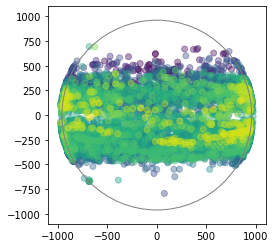

In [4]:
fig, ax = plt.subplots()
cmap="viridis"
flares_p = flare_list[flare_list["hgs_lat"]>-60]
im = ax.scatter(flares_p["hpc_x"], flares_p["hpc_y"], alpha=0.4, #s=5*flares_p["goes_class_val"]*1e6,
            c=flares_p["tt"]/60/60/60/60, cmap=cmap)
circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
ax.add_artist(circle1)
ax.set_aspect("equal")
ax.set_xlim(-1100, 1100)
ax.set_ylim(-1100, 1100)

Text(0.5, 0, 'HPC Y')

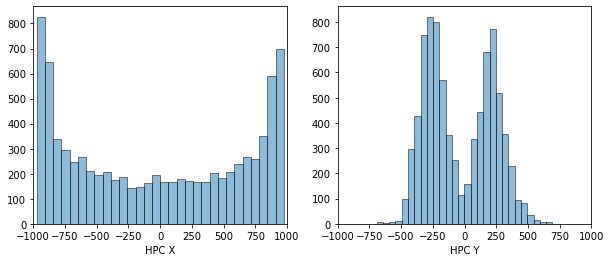

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
_ = ax[0].hist(flares_p["hpc_x"], bins=30, alpha=0.5, edgecolor="k")
_ = ax[1].hist(flares_p["hpc_y"], bins=30, alpha=0.5, edgecolor="k")

ax[0].set_xlim(-1000, 1000)
ax[1].set_xlim(-1000, 1000)

ax[0].set_xlabel("HPC X")
ax[1].set_xlabel("HPC Y")

Text(0, 0.5, 'Integrated flux')

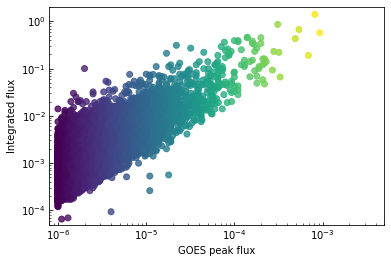

In [6]:
plt.scatter(flare_list["goes_class_val"], flare_list["integrated_flux"], 
            c=flare_list["goes_class_val"], alpha=0.8, norm=LogNorm())
plt.yscale("log")
plt.xscale("log")
plt.tick_params(which="both", direction="in")
plt.xlim(8e-7, 5e-3)
plt.ylim(5e-5, 2)

plt.xlabel("GOES peak flux")
plt.ylabel("Integrated flux")

In [7]:
flare_list.head()

,event_starttime,event_peaktime,event_endtime,goes_class_ind,goes_class,goes_class_val,integrated_flux,noaa_ar,position_hgs,hgs_lat,hgs_lon,hpc_x,hpc_y,tt,matchtime
0,2010-01-02 07:09:00,2010-01-02 07:24:00,2010-01-02 07:40:00,C,C1.0,0.000001,0.00120,11039,S26W41,-26.0,41.0,577.144640,-391.832322,0.0,2010-01-02 00:30
1,2010-01-02 14:08:00,2010-01-02 14:16:00,2010-01-02 14:24:00,C,C2.6,0.000003,0.00140,0,S28W40,-28.0,40.0,555.500664,-421.928656,25140.0,2010-01-02 00:30
2,2010-01-02 22:57:00,2010-01-02 23:19:00,2010-01-02 23:35:00,C,C3.1,0.000003,0.00450,11039,S27W45,-27.0,45.0,616.526246,-408.760595,56880.0,2010-01-02 00:30
3,2010-01-03 01:17:00,2010-01-03 01:22:00,2010-01-03 01:31:00,C,C2.0,0.000002,0.00110,11039,S28W49,-28.0,49.0,651.925348,-426.472138,65280.0,2010-01-03 00:30
4,2010-01-04 03:36:00,2010-01-04 03:40:00,2010-01-04 03:42:00,C,C1.3,0.000001,0.00021,11039,S28W63,-28.0,63.0,769.009519,-435.069978,160020.0,2010-01-04 00:30


## Read in AR data

In [8]:
ar_data = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/AR_analysis/SRS_all_2010-2018.csv")
ar_data = ar_data[ar_data["ID"].isin(["I"])]
ar_data["matchtime"] = ar_data["date"]
ar_data["noaa_ar"] = ar_data["Number"]

In [9]:
ar_data.keys()

Index(['ID', 'Number', 'Carrington Longitude', 'Area', 'Z',
       'Longitudinal Extent', 'Number of Sunspots', 'Mag Type', 'Latitude',
       'Longitude', 'date', 'matchtime', 'noaa_ar'],
      dtype='object')

In [10]:
ar_data.head()

,ID,Number,Carrington Longitude,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude,date,matchtime,noaa_ar
0,I,11039,54.0,130.0,Dai,6.0,8.0,Beta,-28.0,21.0,2010-01-01 00:30,2010-01-01 00:30,11039
1,I,11039,54.0,120.0,Dso,9.0,6.0,Beta,-27.0,35.0,2010-01-02 00:30,2010-01-02 00:30,11039
3,I,11039,52.0,190.0,Dso,8.0,12.0,Beta,-28.0,46.0,2010-01-03 00:30,2010-01-03 00:30,11039
5,I,11039,52.0,220.0,Dso,7.0,10.0,Beta,-29.0,59.0,2010-01-04 00:30,2010-01-04 00:30,11039
7,I,11039,52.0,150.0,Dso,7.0,5.0,Beta,-28.0,72.0,2010-01-05 00:30,2010-01-05 00:30,11039


In [11]:
len(ar_data)

11885

## Merge flare list with AR data for flares that have AR information

In [12]:
print("Around {:.2f}% flares have no AR data".format(100*np.sum(flare_list["noaa_ar"].isin([0]))/len(flare_list)))

Around 10.89% flares have no AR data


### Inspect at flares with no active region data

In [13]:
flares_no_ar = flare_list[flare_list["noaa_ar"].isin([0])]

In [14]:
flares_no_ar["goes_class_ind"].value_counts()

C    912
M     24
Name: goes_class_ind, dtype: int64

(-1100.0, 1100.0)

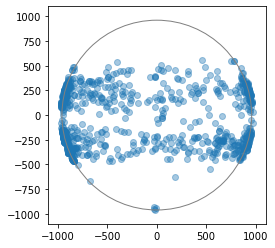

In [15]:
fig, ax = plt.subplots()
cmap="viridis"

im = ax.scatter(flares_no_ar["hpc_x"], flares_no_ar["hpc_y"], alpha=0.4, cmap=cmap)
circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
ax.add_artist(circle1)
ax.set_aspect("equal")
ax.set_xlim(-1100, 1100)
ax.set_ylim(-1100, 1100)

Looking at the positions of the flares that have no AR data make sense, most of them are located when the AR was coming onto disk, so there was probably not yet an AR defined/numbered.

Text(0.5, 1.0, 'Flares with no AR association')

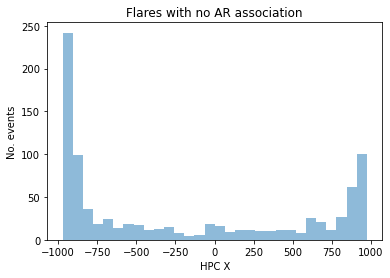

In [16]:
_ = plt.hist(flares_no_ar["hpc_x"], bins=30, alpha=0.5)
plt.ylabel("No. events")
plt.xlabel("HPC X")
plt.title("Flares with no AR association")

## Now lets merge AR data with flare list

In [17]:
flare_ar_df = pd.merge(flare_list, ar_data, how="left", on=["matchtime", "noaa_ar"])

In [18]:
len(flare_ar_df)

8597

In [19]:
flare_ar = flare_ar_df[flare_ar_df["noaa_ar"]!=0]

In [20]:
flare_ar.head(1)

,event_starttime,event_peaktime,event_endtime,goes_class_ind,goes_class,goes_class_val,integrated_flux,noaa_ar,position_hgs,hgs_lat,...,Number,Carrington Longitude,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude,date
0,2010-01-02 07:09:00,2010-01-02 07:24:00,2010-01-02 07:40:00,C,C1.0,0.000001,0.0012,11039,S26W41,-26.0,...,11039.0,54.0,120.0,Dso,9.0,6.0,Beta,-27.0,35.0,2010-01-02 00:30


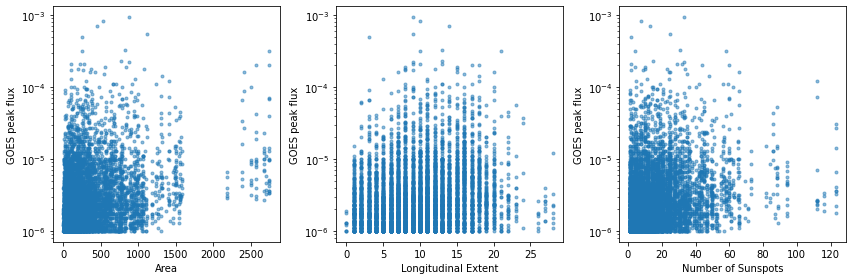

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(flare_ar["Area"], flare_ar["goes_class_val"], marker='.', ls='', alpha=0.5)
ax[0].set_yscale("log")
ax[0].set_ylabel("GOES peak flux")
ax[0].set_xlabel("Area")

ax[1].plot(flare_ar["Longitudinal Extent"], flare_ar["goes_class_val"], marker='.', ls='', alpha=0.5)
ax[1].set_yscale("log")
ax[1].set_ylabel("GOES peak flux")
ax[1].set_xlabel("Longitudinal Extent")

ax[2].plot(flare_ar["Number of Sunspots"], flare_ar["goes_class_val"], marker='.', ls='', alpha=0.5)
ax[2].set_yscale("log")
ax[2].set_ylabel("GOES peak flux")
ax[2].set_xlabel("Number of Sunspots")

plt.tight_layout()

In [22]:
flare_ar["Z"].unique()

array(['Dso', 'Bxo', 'Dhc', 'Eki', 'Cki', nan, 'Dho', 'Cso', 'Dkc', 'Fkc',
       'Eac', 'Fsi', 'Esc', 'Dao', 'Dki', 'Dai', 'Esi', 'Dro', 'Eso',
       'Dsi', 'Hkx', 'Cao', 'Cro', 'Cri', 'Dri', 'Hax', 'Cko', 'Axx',
       'Eai', 'Ehi', 'Hsx', 'Hrx', 'Dko', 'Ekc', 'Ehc', 'Eao', 'Fko',
       'Eko', 'Fki', 'Fso', 'Dhi', 'Cai', 'Csi', 'Cho', 'Eho', 'Fho',
       'Dsc', 'Hhx', 'Fhi', 'Ero', 'Bxi', 'Eri', 'Fhc', 'Dac', 'Fac',
       'Fao', 'Chi', 'Fai', 'Fsc'], dtype=object)

In [23]:
flare_ar["Mag Type"].unique()

array(['Beta', nan, 'Beta-Gamma', 'Beta-Gamma-Delta', 'Beta-Delta',
       'Alpha'], dtype=object)

## Lets look at the individual active regions

In [24]:
flare_ar = flare_ar.dropna()

In [25]:
unique_ar = flare_ar["noaa_ar"].unique()

In [26]:
len(unique_ar)

686

In [27]:
unique_df = flare_ar_df[flare_ar_df.noaa_ar.isin([unique_ar[0]])]

In [28]:
np.sum(unique_df["goes_class_ind"].isin(["C"]))

4

In [29]:
events = []
for ar in unique_ar:
    unique_df = flare_ar_df[flare_ar_df.noaa_ar.isin([ar])]
    event = {}
    event["ar_num"] = ar
    event["number_flares"] = len(unique_df)
    event["c_flares"] = np.sum(unique_df["goes_class_ind"].isin(["C"]))
    event["m_flares"] = np.sum(unique_df["goes_class_ind"].isin(["M"]))
    event["x_flares"] = np.sum(unique_df["goes_class_ind"].isin(["X"]))
    event["max_flare"] = np.max(unique_df["goes_class_val"])
    event["max_area"] = np.max(unique_df["Area"])
    event["max_sunspots"] = np.max(unique_df["Number of Sunspots"])    
    event["ar_class_max"] = unique_df.iloc[np.argmax(unique_df["goes_class_val"])]["Mag Type"]
    events.append(event)

events = pd.DataFrame(events)

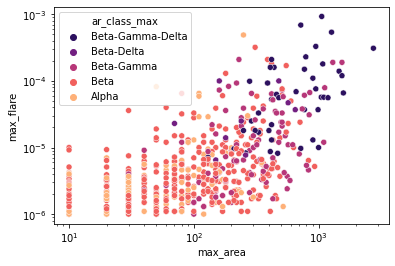

In [30]:
events = events[events.max_area>0]

order = ['Alpha', 'Beta', 'Beta-Gamma',  'Beta-Delta',  'Beta-Gamma-Delta']
sns.scatterplot(data=events, x="max_area", y="max_flare", hue="ar_class_max", palette="magma", hue_order=order[::-1])
plt.xscale("log")
plt.yscale("log")


### Make same plot as Sammis et al. 2000

Text(0, 0.5, 'Max X-ray flux (Wm$^{-2}$)')

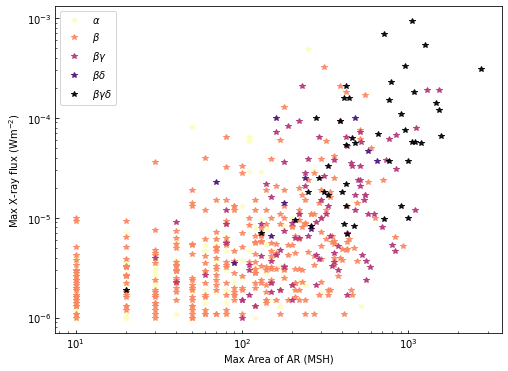

In [31]:
order = ['Alpha', 'Beta', 'Beta-Gamma',  'Beta-Delta',  'Beta-Gamma-Delta']
labels = [r'$\alpha$', r'$\beta$', r'$\beta\gamma$', r'$\beta\delta$', r'$\beta\gamma\delta$']
marker = ['o', '.', '+', '^', '*']
colors = ['pink', 'green', 'blue', 'yellow', 'red']
colors=plt.cm.magma_r(np.linspace(0,1,len(order)))
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(order)):
    aa = events[events["ar_class_max"].isin([order[i]])]
    plt.plot(aa["max_area"], aa["max_flare"], marker="*", ls='', color=colors[i], alpha=0.9, 
             label=labels[i])

plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.tick_params(which="both", direction="in")
plt.xlabel("Max Area of AR (MSH)")
plt.ylabel("Max X-ray flux (Wm$^{-2}$)")

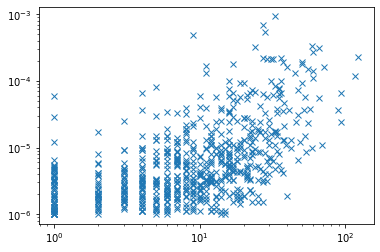

In [32]:
plt.plot(events["max_sunspots"], events["max_flare"], marker='x', ls='')
plt.yscale("log")
plt.xscale("log")

## CME data

To match positions of flares to CMEs we need the HCR coordintes - particularly the Phi angle

In [33]:
hpc_coords = SkyCoord(flare_list["hpc_x"]*u.arcsec, flare_list["hpc_y"]*u.arcsec, 
                      frame=frames.Helioprojective, obstime=flare_list["event_starttime"], 
                      observer="earth")

hcr_coords = hpc_coords.transform_to(frames.Heliocentric)
phi = hcr_coords.cylindrical.phi.wrap_at(360*u.deg).value

flare_list["phi"] = phi-90


flare_list.loc[(flare_list.phi < 0),'phi']=flare_list.phi+360

Lets just make sure these Phi values makes sense

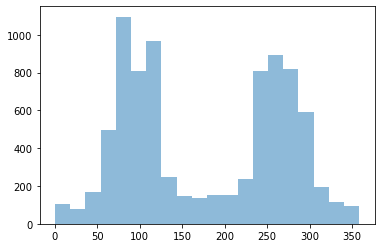

In [34]:
_ = plt.hist(flare_list["phi"], alpha=0.5, bins=20)

## Read in CME list

In [35]:
cme_list = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/cme_lists/final_cme_list_2010_2018.csv")
cme_list["start_time_c2"] = pd.to_datetime(cme_list.date + cme_list.time, format="%Y/%m/%d%H:%M:%S") 

def get_times(x):
    xx = x.split()
    if len(xx)==3:
        return pd.to_datetime(" ".join(xx[1:]))
    else:
        return np.nan

cme_list["onset_times1"] = cme_list.onset_times1.map(get_times)
cme_list["onset_times2"] = cme_list.onset_times2.map(get_times)

In [36]:
cme_list.head()

,date,time,central_pa,width,linear_speed,2nd_order_speed_inital,2nd_order_speed_final,2nd_order_speed_20R,accel,mass,kinetic_energy,MPA,remarks,time_c2,onset_times1,onset_times2,onset_times2_rsun,quality_index,quality_val,start_time_c2
0,2010/01/01,06:54:03,354,6,330,269,396,959,35.5*,-------,-------,355,Very Poor Event; Only 3 points; Only C2,2010-01-01 06:54:03,2010-01-01 05:50:03,2010-01-01 04:48:01,#ONSET2_RSUN: 1.38,#QUALITY_INDEX: 0 (Ill-Defined),0,2010-01-01 06:54:03
1,2010/01/01,08:30:03,248,75,148,60,244,220,1.9*,4.2e+14,4.6e+28,253,Poor Event,2010-01-01 08:30:03,2010-01-01 07:11:32,2009-12-31 23:10:35,#ONSET2_RSUN: 1.98,#QUALITY_INDEX: 1 (Poor),1,2010-01-01 08:30:03
2,2010/01/01,17:06:03,49,21,729,764,694,700,-3.9,4.0e+14,1.1e+30,52,NaN,2010-01-01 17:06:03,2010-01-01 16:45:44,2010-01-01 16:48:50,#ONSET2_RSUN: 1.00,#QUALITY_INDEX: 3 (Typical),3,2010-01-01 17:06:03
3,2010/01/02,07:31:38,100,14,141,123,159,176,0.8*,-------,-------,106,Very Poor Event,2010-01-02 07:31:38,2010-01-02 02:18:04,2010-01-02 00:45:03,#ONSET2_RSUN: 1.00,#QUALITY_INDEX: 0 (Ill-Defined),0,2010-01-02 07:31:38
4,2010/01/03,05:30:03,267,50,219,73,375,385,5.9*,6.3e+14,1.5e+29,261,NaN,2010-01-03 05:30:03,2010-01-03 05:43:23,2010-01-03 02:22:08,#ONSET2_RSUN: 1.96,#QUALITY_INDEX: 2 (Fair),2,2010-01-03 05:30:03


Lets just look at the MPA angle of flare

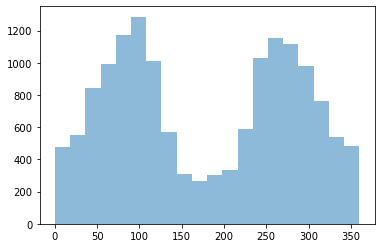

In [37]:
_ = plt.hist(cme_list["MPA"], bins=20, alpha=0.5)

Lets just look at larger flares for now - lets do >C5

In [38]:
flare_interest = flare_list[flare_list["goes_class_val"]>=5e-6]

In [39]:
flare_interest["goes_class_ind"].value_counts()

C    979
M    748
X     49
Name: goes_class_ind, dtype: int64

In [40]:
cme_list["onset_times1"]

0       2010-01-01 05:50:03
1       2010-01-01 07:11:32
2       2010-01-01 16:45:44
3       2010-01-02 02:18:04
4       2010-01-03 05:43:23
                ...        
14807   2018-12-28 17:07:39
14808   2018-12-28 22:39:57
14809   2018-12-28 22:13:41
14810   2018-12-29 20:12:57
14811   2018-12-30 03:25:40
Name: onset_times1, Length: 14764, dtype: datetime64[ns]

In [41]:
def find_cme(flare_list, i):
    """
    Function to find is there is an associated CME for a particular flare
    
    Parameters
    ----------
    flare_list : pd.DataFrame
        flare list to search from
    i : ~int
        index of flare_list row to search for
        
    Returns
    -------
    yes/no : `str` 
        if there is an associated eruption
    positional angle difference : `float`
        absolute value of difference in angle between flare/CME
    quality : `int`
        quality index of eruptive event
    """
    
    
    # check its within 3 hours of flare
    cme_list_compare = cme_list[(cme_list["start_time_c2"]>=flare_list.iloc[i]["event_starttime"]\
                                 -datetime.timedelta(minutes=5)) &
                                (cme_list["start_time_c2"]<=flare_list.iloc[i]["event_starttime"]\
                                 +datetime.timedelta(hours=2))]
    
    # make sure the position locations make sense - absolute value <45 degrees between two
    cme_list_compare = cme_list_compare[np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi)<=cme_list_compare.width]
    
    # checks outputs and returns values if CMEs available
    if len(cme_list_compare)==0:
        return "no", np.nan, 0
    
    elif len(cme_list_compare)==1:
        return "yes", np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi).values[0], cme_list_compare.quality_val.values[0]
    
    else:
#         print("more that one! {:d} has {:d} CMEs".format(i, len(cme_list_compare)))
#         print(cme_list_compare.quality_val.values, np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi).values)
        return "yes", np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi).values[0], cme_list_compare.quality_val.values[0]

    



In [42]:
find_cme(flare_interest, 0)

('no', nan, 0)

In [43]:
cmes = []; angle_list = []; qual = []
for i in range(len(flare_interest)):
    cme, ang, q = find_cme(flare_interest, i)
    cmes.append(cme)
    angle_list.append(ang)
    qual.append(q)
    
flare_interest["cmes"] = cmes
flare_interest["angles"] = angle_list
flare_interest["qual"] = qual

In [44]:
flare_x = flare_interest[flare_interest["goes_class_ind"].isin(["X"])]
flare_m = flare_interest[flare_interest["goes_class_ind"].isin(["M"])]
flare_c = flare_interest[flare_interest["goes_class_ind"].isin(["C"])]




print("X \n",100*flare_x["cmes"].value_counts()/len(flare_x))
print("M \n",100*flare_m["cmes"].value_counts()/len(flare_m))
print("C \n",100*flare_c["cmes"].value_counts()/len(flare_c))

X 
 yes    85.714286
no     14.285714
Name: cmes, dtype: float64
M 
 no     53.342246
yes    46.657754
Name: cmes, dtype: float64
C 
 no     67.926456
yes    32.073544
Name: cmes, dtype: float64


In [45]:
flare_interest["dur_peak"] = [x.total_seconds() for x in pd.to_datetime(flare_interest["event_peaktime"]) - pd.to_datetime(flare_interest["event_starttime"])]
flare_interest["dur_full"] = [x.total_seconds() for x in pd.to_datetime(flare_interest["event_endtime"]) - pd.to_datetime(flare_interest["event_starttime"])]



In [46]:
flare_cmes = flare_interest[(flare_interest.qual>2)]
flare_nocmes = flare_interest[(flare_interest.qual<=2)]

In [47]:
len(flare_cmes)

286

In [48]:
len(flare_nocmes)

1490

In [49]:
flare_cmes_c = flare_cmes[flare_cmes["goes_class_ind"].isin(["M"])]; print(len(flare_cmes_c))
flare_nocmes_c = flare_nocmes[flare_nocmes["goes_class_ind"].isin(["M"])]; print(len(flare_cmes_c))

161
161


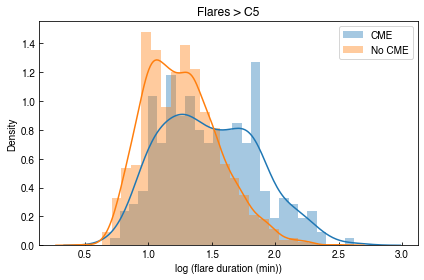

In [50]:
plt.rcParams['font.family'] = 'Helvetica'
sns.distplot(np.log10(flare_cmes.dur_full/60), bins=26, label="CME", )
sns.distplot(np.log10(flare_nocmes.dur_full/60), bins=26, label="No CME")
plt.legend()
plt.xlabel("log (flare duration (min))")
plt.title("Flares > C5")
ax = plt.gca()
ax.tick_params(which="both", direction="in")
plt.tight_layout()


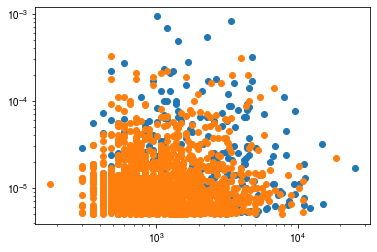

In [51]:
plt.scatter(flare_cmes.dur_full, flare_cmes.goes_class_val)
plt.scatter(flare_nocmes.dur_full, flare_nocmes.goes_class_val)
plt.xscale("log")
plt.yscale("log")

In [52]:
flare_list["dur_peak"] = [x.total_seconds() for x in pd.to_datetime(flare_list["event_peaktime"]) - pd.to_datetime(flare_list["event_starttime"])]
flare_list["dur_full"] = [x.total_seconds() for x in pd.to_datetime(flare_list["event_endtime"]) - pd.to_datetime(flare_list["event_starttime"])]


flare_list = flare_list[flare_list["dur_full"]!=0]

flare_x = flare_list[flare_list["goes_class_ind"].isin(["X"])]
flare_m = flare_list[flare_list["goes_class_ind"].isin(["M"])]
flare_c = flare_list[flare_list["goes_class_ind"].isin(["C"])]



In [53]:
len(flare_list)

8597

<AxesSubplot:xlabel='dur_full', ylabel='Density'>

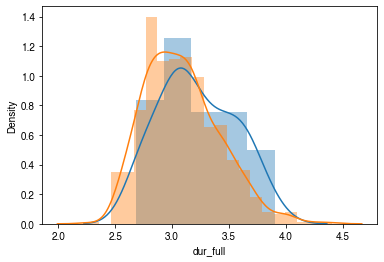

In [54]:
sns.distplot(np.log10(flare_x["dur_full"]))
sns.distplot(np.log10(flare_m["dur_full"]))
# sns.distplot(np.log10(flare_c["dur_full"]))